###  This notebook was created to 

- study the spread and activity of COVID19 virus in DC Metro area
- comparison of results with other states/counties
- use of new visualization techniques


### Thanks

Inspired by this great kernel: https://www.kaggle.com/jmarfati/actual-spread-of-covid19-us-county-level-analysis

Plotly visualizations: 

- https://www.kaggle.com/samusram/covid-19-person-level-drill-down-czechia-canada
- https://www.kaggle.com/artgor/finland-and-coronavirus

In [1]:
%matplotlib inline

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import gc
from urllib.request import urlopen
import json
import requests

import sys
from itertools import chain
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('fivethirtyeight')

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

In [3]:
def display_missing(df, head=True):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

### Load latest US data by county

In [4]:
%%time

df_cases = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv')
df_cases = df_cases.melt(id_vars=["countyFIPS", "County Name", "State", 'stateFIPS'], var_name="Date", value_name="Value")
df_cases = df_cases.rename(columns={'countyFIPS': 'fips', 'Value': 'cases', "County Name":'county', 'State':'state', 'Date':'date'})
df_cases.date = pd.to_datetime(df_cases.date)

df_deaths = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_deaths_usafacts.csv')
df_deaths = df_deaths.melt(id_vars=["countyFIPS", "County Name", "State", 'stateFIPS'], var_name="Date", value_name="Value")
df_deaths = df_deaths.rename(columns={'countyFIPS': 'fips', 'Value': 'deaths', 'Date':'date'})
df_deaths = df_deaths[['fips', 'date', 'deaths']]
df_deaths.date = pd.to_datetime(df_deaths.date)

df_all = df_cases.merge(df_deaths, how='left', left_on=['fips', 'date'], right_on=['fips', 'date'])
df_all.drop(df_all[df_all['fips'] == 0].index, inplace=True)
df_all = df_all.reset_index(drop=True)

df_pop = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv')[['countyFIPS', 'population']]
df_pop = df_pop.rename(columns={'countyFIPS': 'fips'})
df_pop.fips = df_pop.fips.astype(int)
df_pop.population = df_pop.population.astype(int)

df_all = df_all.merge(df_pop, how='left', left_on=['fips'], right_on=['fips']).drop('stateFIPS', axis=1)

us_confirmed = df_all.sort_values(by=['date', 'state', 'county' ])
us_confirmed.reset_index(drop=True)
us_confirmed['county'] = us_confirmed['county'].apply(lambda x: x.replace(' County', '') )

latest_date = us_confirmed.date.max()

## drop dates earlier then 3/1/2020
us_confirmed.drop(us_confirmed[us_confirmed['date'] < pd.to_datetime('03-15-2020')].index, inplace=True)
us_confirmed

CPU times: user 1.64 s, sys: 441 ms, total: 2.08 s
Wall time: 7.13 s


fips                      county state       date  cases  deaths  \
166752   2013      Aleutians East Borough    AK 2020-03-15      0       0   
166753   2016  Aleutians West Census Area    AK 2020-03-15      0       0   
166755   2050          Bethel Census Area    AK 2020-03-15      0       0   
166756   2060         Bristol Bay Borough    AK 2020-03-15      0       0   
166762   2110  City and Borough of Juneau    AK 2020-03-15      0       0   
...       ...                         ...   ...        ...    ...     ...   
374250  56037                  Sweetwater    WY 2020-05-19     24       0   
374251  56039                       Teton    WY 2020-05-19    100       1   
374252  56041                       Uinta    WY 2020-05-19     11       0   
374253  56043                    Washakie    WY 2020-05-19     16       0   
374254  56045                      Weston    WY 2020-05-19      0       0   

        population  
166752      3337.0  
166753      5634.0  
166755     18386.0  
166756       836.0  
166762     31974.0  
...            ...  
374250     42343.0  
374251     23464.0  
374252     20226.0  
374253      7805.0  
374254      6927.0  

[207570 rows x 7 columns]

In [5]:
%%time

## https://www.kaggle.com/jmarfati/actual-spread-of-covid19-us-county-level-analysis

## adding mortality features
us_confirmed['mortality'] = us_confirmed['deaths']/ us_confirmed['cases']
us_confirmed['mortality'] = us_confirmed['mortality'].fillna(0)

us_confirmed['deaths_per_million'] = us_confirmed['deaths'] * 1000000/ us_confirmed['population']
us_confirmed['cases_per_million'] = us_confirmed['cases'] * 1000000/ us_confirmed['population']

# Results of recent antibody test in California suggest that the number of people likely 
# infected is 28 to 80 time the number of confirmed cases. If indeed the spread is 28-fold; 
# the distribution of percentage of population carrying Covid-19 antibody is displayed below    
# https://news.usc.edu/168987/antibody-testing-results-covid-19-infections-los-angeles-county/

us_confirmed['likely_infected_80'] = np.round(us_confirmed['cases'] * 80/ us_confirmed['population'], 2)
us_confirmed['likely_infected_80'] = np.clip(us_confirmed['likely_infected_80'], 0, 1)
us_confirmed['likely_infected_28'] = np.round(us_confirmed['cases'] * 28/ us_confirmed['population'], 2)
us_confirmed['likely_infected_28'] = np.clip(us_confirmed['likely_infected_28'], 0, 1)

us_confirmed = us_confirmed.replace([np.nan, np.inf, -np.inf], 0)   
us_confirmed = us_confirmed[us_confirmed['fips'] > 0]

## save dataset
us_confirmed.to_csv('us-daily-counties-population-permil-likely-infected.csv')
us_confirmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207570 entries, 166752 to 374254
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   fips                207570 non-null  int64         
 1   county              207570 non-null  object        
 2   state               207570 non-null  object        
 3   date                207570 non-null  datetime64[ns]
 4   cases               207570 non-null  int64         
 5   deaths              207570 non-null  int64         
 6   population          207570 non-null  float64       
 7   mortality           207570 non-null  float64       
 8   deaths_per_million  207570 non-null  float64       
 9   cases_per_million   207570 non-null  float64       
 10  likely_infected_80  207570 non-null  float64       
 11  likely_infected_28  207570 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(3), object(2)
memory usage: 20.6+ MB
CPU 

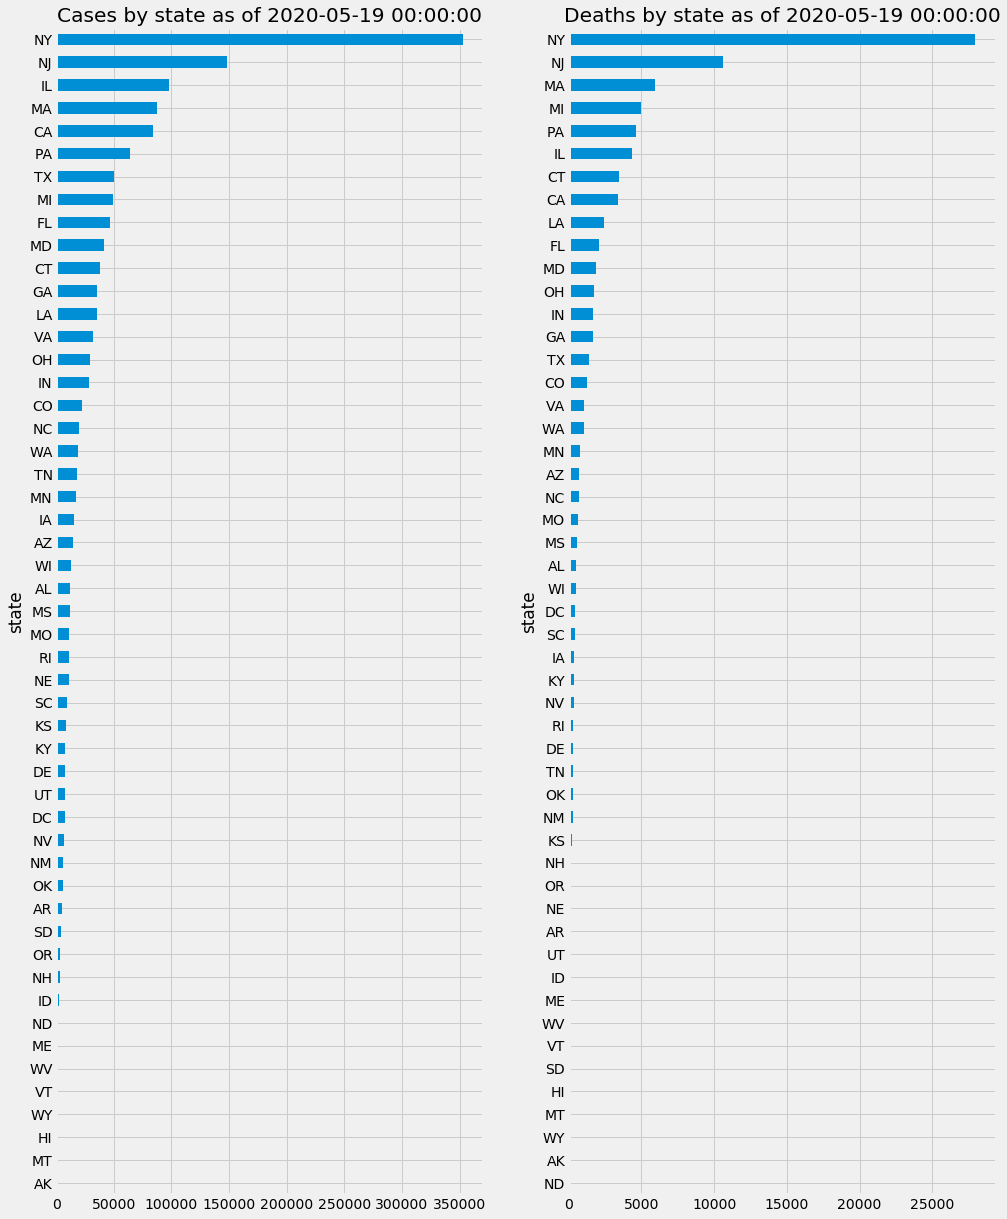

In [6]:
cases_by_state = us_confirmed[us_confirmed['date'] == latest_date].groupby(by=['state'])['cases'].sum().sort_values()
deaths_by_state = us_confirmed[us_confirmed['date'] == latest_date].groupby(by=['state'])['deaths'].sum().sort_values()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 20))
ax1.title.set_text(F'Cases by state as of {latest_date}')
cases_by_state.plot(kind='barh', ax=ax1)

ax2.title.set_text(F'Deaths by state as of {latest_date}')
deaths_by_state.plot(kind='barh', ax=ax2)

### Maryland, DC and Virginia

In [7]:
def fill_for_state( us_df, state, valid_counties):
    """this function extract state data from US dataset, filling missisng dates for counties"""
    
    state_df = us_df[us_df['state']==state]
    ## data cleanup
    state_df = state_df[state_df['county'].isin(valid_counties)]
    state_df = state_df.sort_values(by='date').reset_index(drop=True)
    
    ## we need to insert missing dates for counties
    unique_dates = state_df['date'].unique()

    i = 0
    added_rows = dict()
    for idx, d in enumerate(unique_dates):
        one_day = state_df[state_df['date'] == d]
        for county in valid_counties:
            exists = one_day[ one_day['county'] == county].any()
            if not exists['date']:
                fips = state_df[ state_df['county'] == county]['fips']
                population = state_df[ state_df['county'] == county]['population']
                added_rows[i] = { 'date':d, 'county':county, 'state':state, 'fips':fips.iloc[0], 'cases':0, 'deaths':0, 'population':population.iloc[0]}
                i = i + 1
                
    added = pd.DataFrame.from_dict(added_rows, "index")
    #print(f'missing rows: {len(added)}')
    state_df = pd.concat([state_df, added]) 
    state_df = state_df.replace([np.nan, np.inf, -np.inf], 0)   
    state_df = state_df.sort_values(by='date').reset_index(drop=True)
    return state_df

In [8]:
%%time

## get MD dataset
md_counties = np.unique(us_confirmed[us_confirmed['state']=='MD']['county'].values)
md_df = fill_for_state(us_confirmed, 'MD', md_counties)
md_df.to_csv('us-md-daily-counties-population-permil-likely-infected.csv')

## get VA dataset
va_counties = np.unique(us_confirmed[us_confirmed['state']=='VA']['county'].values)
va_df = fill_for_state(us_confirmed, 'VA', va_counties)
va_df.to_csv('us-va-daily-counties-population-permil-likely-infected.csv')

## get DC dataset, no counties
dc_df = us_confirmed[us_confirmed['state']=='DC']


def to_daily_num(grp):
    grp['cases'] = grp['cases'] - grp['cases'].shift()
    grp['deaths'] = grp['deaths'] - grp['deaths'].shift()
    return grp

## to daily numbers
dc_df['cases'] = dc_df['cases'] - dc_df['cases'].shift()
dc_df['deaths'] = dc_df['deaths'] - dc_df['deaths'].shift()
dc_df = dc_df.replace([np.nan, np.inf, -np.inf], 0)   

va_df.groupby(by=['county']).apply(to_daily_num)
va_df = va_df.replace([np.nan, np.inf, -np.inf], 0)   

md_df.groupby(by=['county']).apply(to_daily_num)
md_df = md_df.replace([np.nan, np.inf, -np.inf], 0)

CPU times: user 15.7 s, sys: 19.2 ms, total: 15.8 s
Wall time: 15.7 s


In [9]:
def counties_with_top5_cases_by_state(state_df, column, title, ax):    
    unique_dates = np.unique(md_df['date'].apply(lambda x: x.strftime('%Y-%m-%d')).values)
    top5 = state_df[state_df.date == unique_dates.max()].nlargest(5, column)
    date_ticks = range(0, len(unique_dates), 5)
    ax.set_xticks(date_ticks);
    ax.set_xticklabels([unique_dates[i] for i in date_ticks], rotation='vertical');
    ax.set_xlabel('Date');
    sns.lineplot( x=unique_dates, y = state_df[state_df['county'] == top5['county'].values[0]][column], ax=ax)
    if len(top5) > 1:
        sns.lineplot( x=unique_dates, y = state_df[state_df['county'] == top5['county'].values[1]][column], ax=ax)
        sns.lineplot( x=unique_dates, y = state_df[state_df['county'] == top5['county'].values[2]][column], ax=ax)
        sns.lineplot( x=unique_dates, y = state_df[state_df['county'] == top5['county'].values[3]][column], ax=ax)
        sns.lineplot( x=unique_dates, y = state_df[state_df['county'] == top5['county'].values[4]][column], ax=ax)
    ax.legend(top5['county'].values, loc='upper left', shadow=True)
    ax.set_title(title)
    

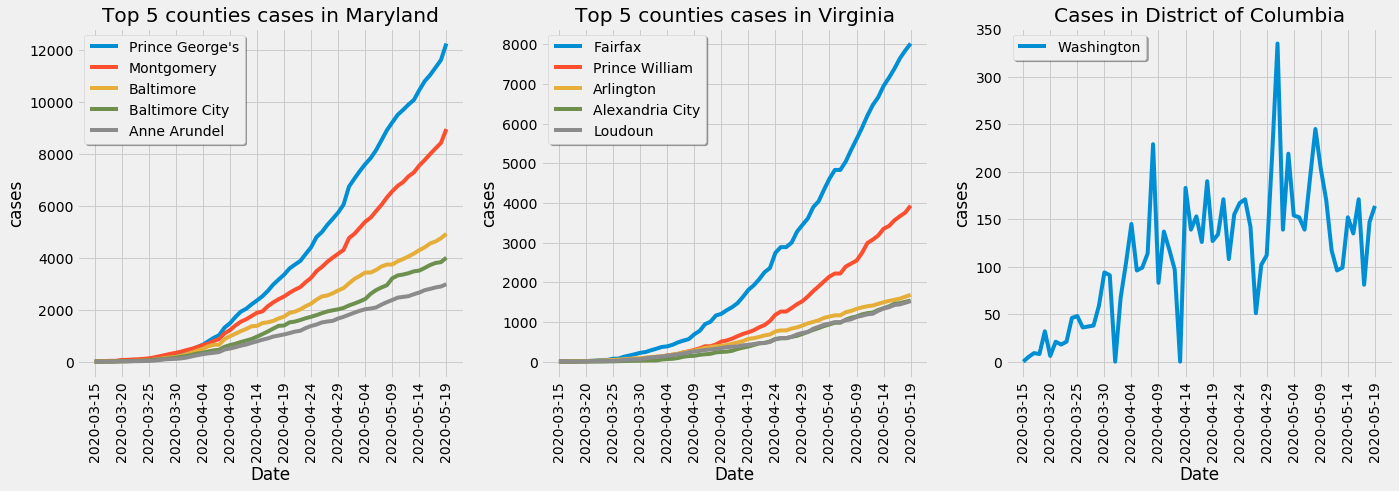

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))
counties_with_top5_cases_by_state(md_df, 'cases', 'Top 5 counties cases in Maryland', ax1)
counties_with_top5_cases_by_state(va_df, 'cases', 'Top 5 counties cases in Virginia', ax2)
counties_with_top5_cases_by_state(dc_df, 'cases', 'Cases in District of Columbia', ax3)
plt.show()

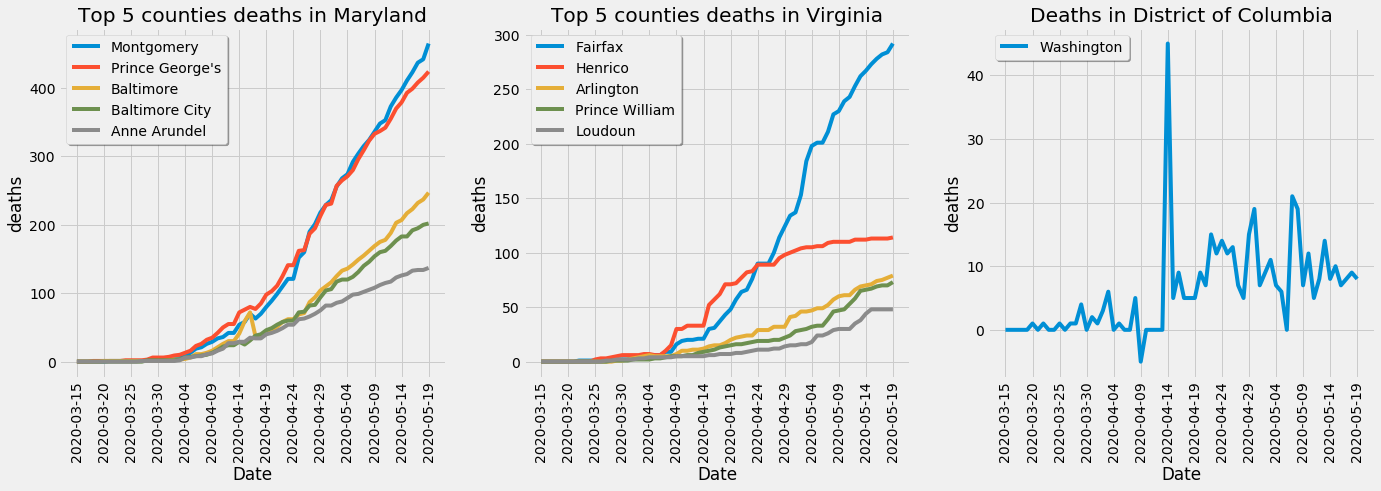

In [11]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))
counties_with_top5_cases_by_state(md_df, 'deaths', 'Top 5 counties deaths in Maryland', ax1)
counties_with_top5_cases_by_state(va_df, 'deaths', 'Top 5 counties deaths in Virginia', ax2)
counties_with_top5_cases_by_state(dc_df, 'deaths', 'Deaths in District of Columbia', ax3)
plt.show()

### Geo data

Text(0.5, 1.0, 'Mortality rate')

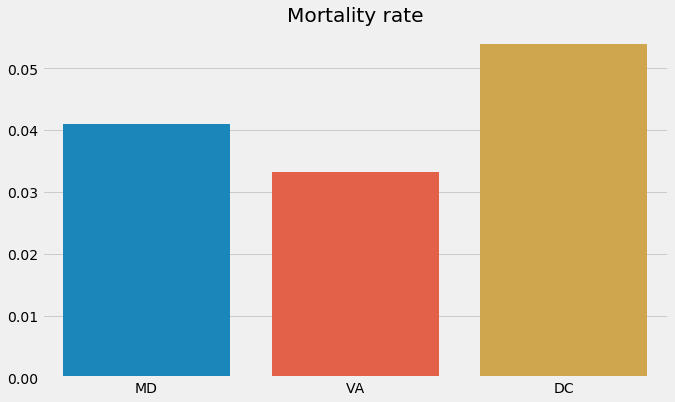

In [12]:
## according to google MD population as of 2020 is 5,773,552, so not exactly sure why there is a difference
md_population = md_df[md_df['date'] == latest_date]['population'].sum()

md_mortality = md_df['deaths'].sum() / md_df['cases'].sum()
va_mortality = va_df['deaths'].sum() / va_df['cases'].sum()
dc_mortality = dc_df['deaths'].sum() / dc_df['cases'].sum()

y = [md_mortality, va_mortality, dc_mortality]
x = ['MD', 'VA', 'DC']

f, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(x=x, y=y, ax=ax)
ax.set_title('Mortality rate')

In [13]:
## this dataset has geo info in it, so let use it
us = pd.read_csv('/kaggle/input/uncover/USAFacts/confirmed-covid-19-cases-in-us-by-state-and-county.csv', header=0, parse_dates=True)
dc_metro_geo = us[us['state_name'].isin(['VA', 'MD', 'DC'])].drop(['state_fips','date', 'confirmed'], axis=1)
dc_metro_geo.drop_duplicates(keep='first', inplace=True)
dc_metro_geo.drop(['county_name','state_name'], inplace=True, axis=1)

## merge
dc_metro = pd.concat([md_df, va_df, dc_df])
dc_metro = dc_metro.merge( dc_metro_geo[['county_fips', 'lat','long','geometry']], how='left', left_on='fips', right_on='county_fips').drop('county_fips', axis=1)
#dc_metro

### Heatmap

In [14]:
## folium use is from notebook
## https://www.kaggle.com/soham1024/covid-19-india-visualization-forecasting

import folium
from folium.plugins import HeatMap

#heat_data = [[[row['Latitude'],row['Longitude']] for index, row in heat_df[heat_df['Weight'] == i].iterrows()] for i in range(0,13)]

In [25]:
md_top10_cases = md_df[md_df.date == latest_date].nlargest(2, 'cases')[['fips','cases']]
md_top10_cases = md_top10_cases.merge(dc_metro[['fips','county', 'lat', 'long']], how='left', left_on='fips', right_on='fips')
md_top10_cases.drop_duplicates(keep='first', inplace=True)

va_top10_cases = va_df[va_df.date == latest_date].nlargest(2, 'cases')[['fips','cases']]
va_top10_cases = va_top10_cases.merge(dc_metro[['fips','county', 'lat', 'long']], how='left', left_on='fips', right_on='fips')
va_top10_cases.drop_duplicates(keep='first', inplace=True)

dc_top_cases = dc_df[dc_df.date == latest_date].nlargest(1, 'cases')[['fips','cases']]
dc_top_cases = dc_top_cases.merge(dc_metro[['fips','county', 'lat', 'long']], how='left', left_on='fips', right_on='fips')
dc_top_cases.drop_duplicates(keep='first', inplace=True)

md_heat_data = [[row['lat'],row['long']] for index, row in md_top10_cases.iterrows()]
va_heat_data = [[row['lat'],row['long']] for index, row in va_top10_cases.iterrows()]
dc_heat_data = [[row['lat'],row['long']] for index, row in dc_top_cases.iterrows()]

heat_data = pd.concat([pd.DataFrame(md_heat_data), pd.DataFrame(va_heat_data), pd.DataFrame(dc_heat_data)])
heat_data = head_data.reset_index(drop=True)

In [30]:
f_map = folium.Map(location=[38.889248, -77.050636], zoom_start=7, tiles='cartodbpositron')
HeatMap(heat_data,radius=20.5, blur = 6.5).add_to(f_map)
f_map

In [31]:
## Convert topology json into geojson
## The code is from https://gist.github.com/perrygeo/1e767e42e8bc54ad7262


def rel2abs(arc, scale=None, translate=None):
    """Yields absolute coordinate tuples from a delta-encoded arc.
    If either the scale or translate parameter evaluate to False, yield the
    arc coordinates with no transformation."""
    if scale and translate:
        a, b = 0, 0
        for ax, bx in arc:
            a += ax
            b += bx
            yield scale[0]*a + translate[0], scale[1]*b + translate[1]
    else:
        for x, y in arc:
            yield x, y

def coordinates(arcs, topology_arcs, scale=None, translate=None):
    """Return GeoJSON coordinates for the sequence(s) of arcs.
    
    The arcs parameter may be a sequence of ints, each the index of a
    coordinate sequence within topology_arcs
    within the entire topology -- describing a line string, a sequence of 
    such sequences -- describing a polygon, or a sequence of polygon arcs.
    
    The topology_arcs parameter is a list of the shared, absolute or
    delta-encoded arcs in the dataset.
    The scale and translate parameters are used to convert from delta-encoded
    to absolute coordinates. They are 2-tuples and are usually provided by
    a TopoJSON dataset. 
    """
    if isinstance(arcs[0], int):
        coords = [
            list(
                rel2abs(
                    topology_arcs[arc if arc >= 0 else ~arc],
                    scale, 
                    translate )
                 )[::arc >= 0 or -1][i > 0:] \
            for i, arc in enumerate(arcs) ]
        return list(chain.from_iterable(coords))
    elif isinstance(arcs[0], (list, tuple)):
        return list(
            coordinates(arc, topology_arcs, scale, translate) for arc in arcs)
    else:
        raise ValueError("Invalid input %s", arcs)

def geometry(obj, topology_arcs, scale=None, translate=None):
    """Converts a topology object to a geometry object.
    
    The topology object is a dict with 'type' and 'arcs' items, such as
    {'type': "LineString", 'arcs': [0, 1, 2]}.
    See the coordinates() function for a description of the other three
    parameters.
    """
    return {
        "type": obj['type'], 
        "coordinates": coordinates(
            obj['arcs'], topology_arcs, scale, translate )}

In [32]:
from shapely.geometry import asShape

# get geo data for plotting
r = requests.get(url='https://raw.githubusercontent.com/deldersveld/topojson/master/countries/us-states/MD-24-maryland-counties.json')
md_json = r.json()

topojson_path = sys.argv[1]
geojson_path = sys.argv[2]

topology = md_json

# file can be renamed, the first 'object' is more reliable
layername = list(topology['objects'].keys())[0]  

features = topology['objects'][layername]['geometries']
scale = topology['transform']['scale']
trans = topology['transform']['translate']

fc = {'type': "FeatureCollection", 'features': []}

for id, tf in enumerate(features):
    f = {'id': id, 'type': "Feature"}
    f['properties'] = tf['properties'].copy()

    geommap = geometry(tf, topology['arcs'], scale, trans)
    geom = asShape(geommap).buffer(0)
    assert geom.is_valid
    f['geometry'] = geom.__geo_interface__

    fc['features'].append(f) 

In [33]:
district_mapping = {
    'Allegany' : 6, 
    'Anne Arundel' : 20, 
    'Baltimore' : 15, 
    'Baltimore City' : 14,
    'Calvert' : 21, 
    'Caroline' : 13, 
    'Carroll' : 3, 
    'Cecil' : 12, 
    'Charles' : 10, 
    'Dorchester' : 11,
    'Frederick' : 22, 
    'Garrett' : 7, 
    'Harford' : 16, 
    'Howard' : 23, 
    'Kent' : 8, 
    'Montgomery' : 1,
    "Prince George's" : 9, 
    "Queen Anne's" : 5, 
    'Somerset' : 4,
    "St. Mary's" : 17, 
    'Talbot' : 2, 
    'Washington' : 18, 
    'Wicomico' : 19,
    'Worcester': 0,    
}

df = md_df[['date','cases', 'county']]
df['total'] = df.sort_values('date').groupby('county').cumsum()
df['id'] = df['county'].apply(lambda x: district_mapping[x])
df['date'] = df['date'].astype(str)


fig = px.choropleth(df,
                    geojson=fc,
                    locations='id',
                    animation_frame='date',
                    color_continuous_scale="OrRd",
                    hover_name='county',
                    range_color=(0, df['total'].max()),
                    color='total',
                   title='Maryland: COVID-19 cases per county')

fig.update_geos(fitbounds="locations", visible=False)
fig.update_geos(projection_type="orthographic")
fig.update_layout(height=600, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

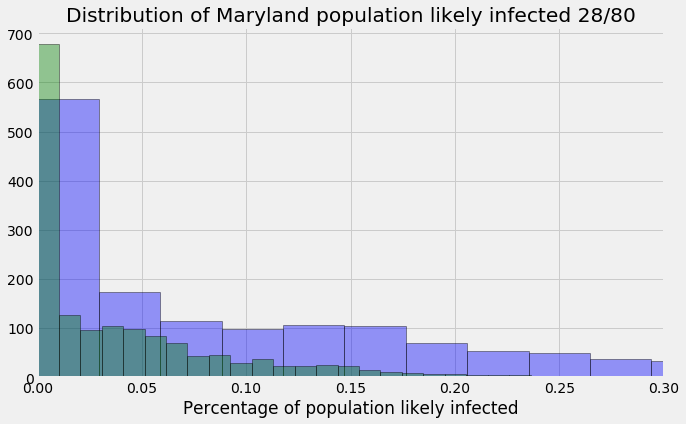

In [34]:
plt.figure(figsize=(10,6))
sns.distplot(md_df.likely_infected_80, hist=True, kde=False, color = 'blue', hist_kws={'edgecolor':'black', 'linewidth':1}, kde_kws={'linewidth': 2})
sns.distplot(md_df.likely_infected_28, hist=True, kde=False, color = 'green', hist_kws={'edgecolor':'black', 'linewidth':1}, kde_kws={'linewidth': 2})
plt.xlim(0, 0.3)
plt.title('Distribution of Maryland population likely infected 28/80')
plt.xlabel('Percentage of population likely infected')
plt.show()

Text(0.5, 1.0, 'Likely spread of virus if spread is 28 fold')

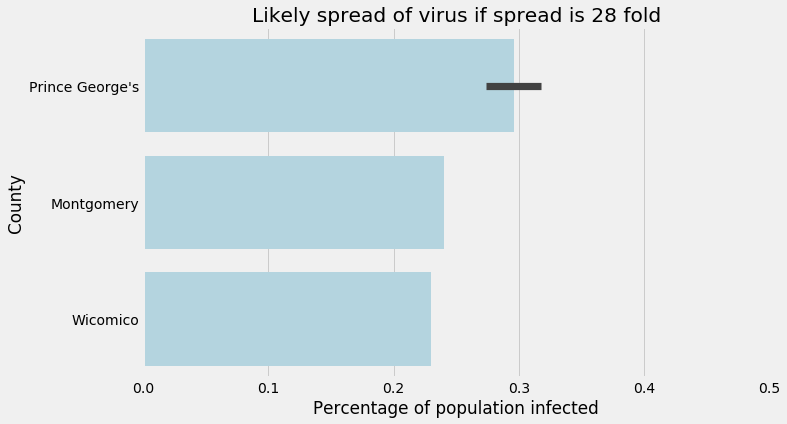

In [35]:
plt.figure(figsize=(10,6))
g=sns.barplot(x='likely_infected_28', y='county',data=md_df.sort_values(['likely_infected_28'], ascending=False).head(20), color="lightblue")
plt.xlim(0, 0.5)
plt.xlabel("Percentage of population infected")
plt.ylabel("County")
plt.title("Likely spread of virus if spread is 28 fold")

Text(0.5, 1.0, 'Likely spread of virus if spread is 80 fold')

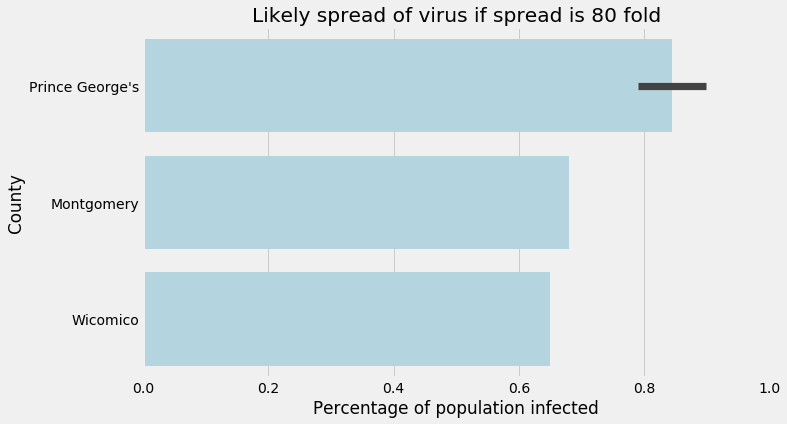

In [36]:
plt.figure(figsize=(10,6))
g=sns.barplot(x='likely_infected_80', y='county',data=md_df.sort_values(['likely_infected_80'], ascending=False).head(20), color="lightblue")
plt.xlim(0, 1)
plt.xlabel("Percentage of population infected")
plt.ylabel("County")
plt.title("Likely spread of virus if spread is 80 fold")